# 1. Multi-class Classification
## 1.1 Dataset

In [1]:
import os
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pathlib import Path

data_file_1 = Path(os.path.abspath("")) / "data" / "ex3data1.mat"
data_set_1 = sio.loadmat(data_file_1)

# every row of X is a flattened 20 * 20 image matrix
# every row of y is a digit index, where [1, ..., 9] means digit [1, ..., 9], [10] means digit [0]
X = np.array(data_set_1["X"])
y = np.array(data_set_1["y"])

print(X)
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


## 1.2 Visualizing the data

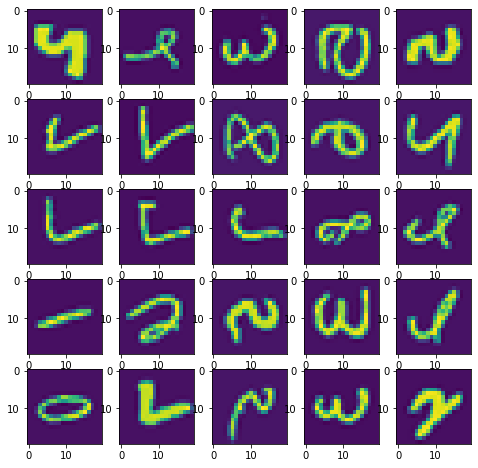

In [2]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
random_indexes = random.choices([i for i in range(X.shape[0])], k = 25)

for i, ax in enumerate(axes.flat):
    ax.imshow(X[random_indexes[i]].reshape(20, 20))

## 1.3 Vectorizing logistic regression
### 1.3.1 Vectorizing the cost function

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    h = sigmoid(X @ theta)
    m = X.shape[0]
    j = 1 / m * (-y.T @ np.log(h) - (1 - y).T @ np.log(1 - h))
    return j.item()

### 1.3.2 Vectorizing the gradient

In [4]:
def gradient(theta, X, y):
    m = X.shape[0]
    gradient = 1 / m * X.T @ (sigmoid(X @ theta) - y)
    return gradient

### 1.3.3 Vectorizing regularized logistic regression

In [5]:
def regularized_cost(theta, lamda, X, y):
    m = X.shape[0]
    regular_theta = np.insert(theta[1:], 0, 0, axis=0)
    logistic_cost = cost(theta, X, y)
    regularize_factor = lamda / (2 * m) * (regular_theta.T @ regular_theta).item()
    return logistic_cost + regularize_factor

def regularized_gradient(theta, lamda, X, y):
    m = X.shape[0]
    regular_theta = np.insert(theta[1:], 0, 0, axis=0)
    logistic_gradient = gradient(theta, X, y)
    regularize_vector = lamda / m * regular_theta
    return logistic_gradient + regularize_vector

theta_t = np.array([[-2], [-1], [1], [2]])
X_t = np.insert(np.array([i for i in range(1, 16)]).reshape((3, 5)).T / 10, 0, np.ones(5), axis=1)
y_t = np.array([[1], [0], [1], [0], [1]])
lambda_t = 3
print(theta_t)
print(X_t)
print(y_t)
print(lambda_t)

cost_t = regularized_cost(theta_t, lambda_t, X_t, y_t)
grad_t = regularized_gradient(theta_t, lambda_t, X_t, y_t)
print(cost_t)
print(grad_t)

[[-2]
 [-1]
 [ 1]
 [ 2]]
[[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]
[[1]
 [0]
 [1]
 [0]
 [1]]
3
2.534819396109744
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


## 1.4 One-vs-all classication

In [6]:
num_labels = 10
lamda = 0.1

def one_vs_all(X, y, num_labels, lamda):
    labels = np.array([i for i in range(1, num_labels + 1)])
    y_list = np.array([[1 if i == l else 0 for i in y] for l in labels])
    learned_theta_matrix = np.empty((0, X.shape[1] + 1))
    for y_ele in y_list:
        res = opt.minimize(fun = cost, x0 = np.zeros((X.shape[1] + 1, 1)), args = (np.insert(X, 0, np.ones(X.shape[0]), axis=1), y_ele), method = 'TNC', jac = gradient)
        learned_theta = res.x
        learned_theta_matrix = np.append(learned_theta_matrix, np.array([learned_theta]), axis=0)
    return learned_theta_matrix

learned_theta_matrix = one_vs_all(X, y, num_labels, lamda)
print(learned_theta_matrix)

[[-3.85687356e+00  0.00000000e+00  0.00000000e+00 ...  8.71274900e-03
   2.87608156e-07  0.00000000e+00]
 [-4.57701012e+00  0.00000000e+00  0.00000000e+00 ...  2.17749123e-01
  -1.02531584e-02  0.00000000e+00]
 [-8.45345412e+00  0.00000000e+00  0.00000000e+00 ... -1.92523712e-04
  -1.16077354e-06  0.00000000e+00]
 ...
 [-1.37072516e+01  0.00000000e+00  0.00000000e+00 ... -7.30424686e+00
   8.43656508e-01  0.00000000e+00]
 [-8.62394195e+00  0.00000000e+00  0.00000000e+00 ... -2.45815965e-01
   1.53957185e-02  0.00000000e+00]
 [-1.30344268e+01  0.00000000e+00  0.00000000e+00 ...  1.34943696e-03
   6.01784102e-05  0.00000000e+00]]


### 1.4.1 One-vs-all prediction

In [7]:
def predict_one_vs_all(theta_matrix, X):
    input_X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    res_matrix = input_X @ theta_matrix.T
    prediction = np.argmax(res_matrix, axis=1) + 1
    return prediction

pred = predict_one_vs_all(learned_theta_matrix, X)
accuracy = np.sum(pred == y.flatten()) / y.shape[0]
print(pred)
print(y.flatten())
print(accuracy)

[10 10 10 ...  9  9  9]
[10 10 10 ...  9  9  9]
0.9736


# 2. Neural Networks
## 2.1 Model representation

In [8]:
weights_file = Path(os.path.abspath("")) / "data" / "ex3weights.mat"
weights = sio.loadmat(weights_file)
theta_1 = weights["Theta1"]
theta_2 = weights["Theta2"]
print(theta_1)
print(theta_2)

[[-2.25623899e-02 -1.05624163e-08  2.19414684e-09 ... -1.30529929e-05
  -5.04175101e-06  2.80464449e-09]
 [-9.83811294e-02  7.66168682e-09 -9.75873689e-09 ... -5.60134007e-05
   2.00940969e-07  3.54422854e-09]
 [ 1.16156052e-01 -8.77654466e-09  8.16037764e-09 ... -1.20951657e-04
  -2.33669661e-06 -7.50668099e-09]
 ...
 [-1.83220638e-01 -8.89272060e-09 -9.81968100e-09 ...  2.35311186e-05
  -3.25484493e-06  9.02499060e-09]
 [-7.02096331e-01  3.05178374e-10  2.56061008e-09 ... -8.61759744e-04
   9.43449909e-05  3.83761998e-09]
 [-3.50933229e-01  8.85876862e-09 -6.57515140e-10 ... -1.80365926e-06
  -8.14464807e-06  8.79454531e-09]]
[[-0.76100352 -1.21244498 -0.10187131 -2.36850085 -1.05778129 -2.20823629
   0.56383834  1.21105294  2.21030997  0.44456156 -1.18244872  1.04289112
  -1.60558756  1.30419943  1.37175046  1.74825095 -0.23365648 -1.52014483
   1.15324176  0.10368082 -0.37207719 -0.61530019 -0.1256836  -2.27193038
  -0.71836208 -1.29690315]
 [-0.61785176  0.61559207 -1.26550639  1.

## 2.2 Feedforward propagation and prediction

In [9]:
random_indexes = random.choices([i for i in range(X.shape[0])], k = 25)
X_slice = X[random_indexes]
y_slice = y[random_indexes]
print(X_slice)
print(y_slice)

def predict(theta_1, theta_2, X):
    input_X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    a_2 = sigmoid(input_X @ theta_1.T)
    a_3 = sigmoid(np.insert(a_2, 0, np.ones(a_2.shape[0]), axis=1) @ theta_2.T)
    prediction = np.argmax(a_3, axis=1) + 1
    return prediction

neural_pred = predict(theta_1, theta_2, X_slice)
neural_accuracy = np.sum(neural_pred == y_slice.flatten()) / y_slice.shape[0]
print(neural_pred)
print(y_slice.flatten())
print(neural_accuracy)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 1]
 [ 4]
 [ 8]
 [ 9]
 [ 8]
 [ 3]
 [ 8]
 [ 9]
 [10]
 [10]
 [ 3]
 [ 7]
 [ 2]
 [ 2]
 [10]
 [ 7]
 [ 7]
 [ 7]
 [ 2]
 [ 4]
 [ 4]
 [ 3]
 [ 8]
 [ 8]
 [ 2]]
[ 1  4  8  9  8  3  8  9 10 10  3  7  2  2 10  7  7  7  2  4  4  3  8  8
  2]
[ 1  4  8  9  8  3  8  9 10 10  3  7  2  2 10  7  7  7  2  4  4  3  8  8
  2]
1.0
